# Simulating pET19K_MaSp1_4 Production Limits

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Define ME-Model Solve Functions

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

## 4. Create the MaSp1 Transcription Reaction

Complete the steps necessary to create the MaSp1 Transcription Reaction

In [4]:
locus_id = 'MaSp1'
left_pos =  None
right_pos = None
seq = 'ATGACCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCAAGGTGCGGGTCGCGGTGGTTTAGGCGGTCAGGGTGCGGGTGCGGCTGCTGCAGCTGCGGCAGCGGGTGGTGCTGGGCAAGGCGGTTACGGTGGATTAGGTAGCCAAGGTGCAGGACGCGGAGGTCTTGGTGGACAGGGTGCTGGCGCTGCTGCGGCAGCAGCAGCCGCTGGGGGTGCTGGTCAAGGGGGTTATGGCGGTTTAGGATCTCAGGGTGCGGGACGGGGTGGTCTGGGAGGGCAAGGGGCAGGCGCAGCAGCAGCGGCAGCTGCAGCCGGTGGTGCCGGACAAGGGGGATATGGGGGTCTTGGCTCCCAAGGCGCTGGTCGTGGCGGTCTTGGAGGCCAAGGTGCCGGTGCCGCTGCAGCGGCTGCTGCTGCAGCGGGTCAAGGGGGATACGGTGGTCTGGGATCACAAGGTGGTGGCGCAGGGCAAGGTGGGTATGGGGGTTTAGGTTCGCAAGGTGCTGGCCGTGGGGGACTGGGAGGACAGGGTGCCGGTGCGGCAGCCGCTGCAGCTGCTGCGGGTGGCGCTGGTCAGGGTGGCTATGGCGGATTGGGCTCTCAAGGGGCAGGTCGGGGTGGCTTGGGAGGACAAGGTGCGGGTGCAGCCGCTGCGGCAGCTGCCGCTGGCGGAGCAGGCCAGGGTGGCTACGGTGGACTGGGTTCCCAAGGTGCGGGAAGAGGTGGCTTGGGTGGCCAGGGTGCAGGGGCAGCGGCTGCAGCGGCAGCAGCCTCCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCAAGGTGCGGGTCGCGGTGGTTTAGGCGGTCAGGGTGCGGGTGCGGCTGCTGCAGCTGCGGCAGCGGGTGGTGCTGGGCAAGGCGGTTACGGTGGATTAGGTAGCCAAGGTGCAGGACGCGGAGGTCTTGGTGGACAGGGTGCTGGCGCTGCTGCGGCAGCAGCAGCCGCTGGGGGTGCTGGTCAAGGGGGTTATGGCGGTTTAGGATCTCAGGGTGCGGGACGGGGTGGTCTGGGAGGGCAAGGGGCAGGCGCAGCAGCAGCGGCAGCTGCAGCCGGTGGTGCCGGACAAGGGGGATATGGGGGTCTTGGCTCCCAAGGCGCTGGTCGTGGCGGTCTTGGAGGCCAAGGTGCCGGTGCCGCTGCAGCGGCTGCTGCTGCAGCGGGTCAAGGGGGATACGGTGGTCTGGGATCACAAGGTGGTGGCGCAGGGCAAGGTGGGTATGGGGGTTTAGGTTCGCAAGGTGCTGGCCGTGGGGGACTGGGAGGACAGGGTGCCGGTGCGGCAGCCGCTGCAGCTGCTGCGGGTGGCGCTGGTCAGGGTGGCTATGGCGGATTGGGCTCTCAAGGGGCAGGTCGGGGTGGCTTGGGAGGACAAGGTGCGGGTGCAGCCGCTGCGGCAGCTGCCGCTGGCGGAGCAGGCCAGGGTGGCTACGGTGGACTGGGTTCCCAAGGTGCGGGAAGAGGTGGCTTGGGTGGCCAGGGTGCAGGGGCAGCGGCTGCAGCGGCAGCAGCCTCCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCAAGGTGCGGGTCGCGGTGGTTTAGGCGGTCAGGGTGCGGGTGCGGCTGCTGCAGCTGCGGCAGCGGGTGGTGCTGGGCAAGGCGGTTACGGTGGATTAGGTAGCCAAGGTGCAGGACGCGGAGGTCTTGGTGGACAGGGTGCTGGCGCTGCTGCGGCAGCAGCAGCCGCTGGGGGTGCTGGTCAAGGGGGTTATGGCGGTTTAGGATCTCAGGGTGCGGGACGGGGTGGTCTGGGAGGGCAAGGGGCAGGCGCAGCAGCAGCGGCAGCTGCAGCCGGTGGTGCCGGACAAGGGGGATATGGGGGTCTTGGCTCCCAAGGCGCTGGTCGTGGCGGTCTTGGAGGCCAAGGTGCCGGTGCCGCTGCAGCGGCTGCTGCTGCAGCGGGTCAAGGGGGATACGGTGGTCTGGGATCACAAGGTGGTGGCGCAGGGCAAGGTGGGTATGGGGGTTTAGGTTCGCAAGGTGCTGGCCGTGGGGGACTGGGAGGACAGGGTGCCGGTGCGGCAGCCGCTGCAGCTGCTGCGGGTGGCGCTGGTCAGGGTGGCTATGGCGGATTGGGCTCTCAAGGGGCAGGTCGGGGTGGCTTGGGAGGACAAGGTGCGGGTGCAGCCGCTGCGGCAGCTGCCGCTGGCGGAGCAGGCCAGGGTGGCTACGGTGGACTGGGTTCCCAAGGTGCGGGAAGAGGTGGCTTGGGTGGCCAGGGTGCAGGGGCAGCGGCTGCAGCGGCAGCAGCCTCCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCAAGGTGCGGGTCGCGGTGGTTTAGGCGGTCAGGGTGCGGGTGCGGCTGCTGCAGCTGCGGCAGCGGGTGGTGCTGGGCAAGGCGGTTACGGTGGATTAGGTAGCCAAGGTGCAGGACGCGGAGGTCTTGGTGGACAGGGTGCTGGCGCTGCTGCGGCAGCAGCAGCCGCTGGGGGTGCTGGTCAAGGGGGTTATGGCGGTTTAGGATCTCAGGGTGCGGGACGGGGTGGTCTGGGAGGGCAAGGGGCAGGCGCAGCAGCAGCGGCAGCTGCAGCCGGTGGTGCCGGACAAGGGGGATATGGGGGTCTTGGCTCCCAAGGCGCTGGTCGTGGCGGTCTTGGAGGCCAAGGTGCCGGTGCCGCTGCAGCGGCTGCTGCTGCAGCGGGTCAAGGGGGATACGGTGGTCTGGGATCACAAGGTGGTGGCGCAGGGCAAGGTGGGTATGGGGGTTTAGGTTCGCAAGGTGCTGGCCGTGGGGGACTGGGAGGACAGGGTGCCGGTGCGGCAGCCGCTGCAGCTGCTGCGGGTGGCGCTGGTCAGGGTGGCTATGGCGGATTGGGCTCTCAAGGGGCAGGTCGGGGTGGCTTGGGAGGACAAGGTGCGGGTGCAGCCGCTGCGGCAGCTGCCGCTGGCGGAGCAGGCCAGGGTGGCTACGGTGGACTGGGTTCCCAAGGTGCGGGAAGAGGTGGCTTGGGTGGCCAGGGTGCAGGGGCAGCGGCTGCAGCGGCAGCAGCCTCCGGAGGG'
strand = None
rna_type = 'mRNA'

building.create_transcribed_gene(me, locus_id, rna_type, seq)
building.add_transcription_reaction(me, 'TU_MaSp1', {'MaSp1'}, seq)
print(me.reactions.transcription_TU_MaSp1.reaction)
me.reactions.transcription_TU_MaSp1.update()

717 atp_c + 1950 ctp_c + 882 gtp_c + 567 utp_c --> RNA_MaSp1 + 1305.062631936 mRNA_biomass + 4116 ppi_c


/source/cobrame/cobrame/core/reaction.py:852 UserWarning: RNA Polymerase () not found


###  Add the RNAP to the MaSp1 Transcription Reaction

In [5]:
me.reactions.transcription_TU_MaSp1.transcription_data.RNA_polymerase = 'RNAP70-CPLX'
me.reactions.transcription_TU_MaSp1.update()

List the transcription data ("transcription_data") associated with the MaSp1 transcription reaction ("transcription_TU_MaSp1").

In [6]:
rxn = me.reactions.transcription_TU_MaSp1
data = rxn.transcription_data
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,TU_MaSp1
_model,iJL1678b-ME
_parent_reactions,{'transcription_TU_MaSp1'}
nucleotide_sequence,ATGACCGGTGGTGCAGGTCAGGGTGGTTATGGTGGTCTGGGTAGCCAGGGTGCCGGTCGTGGTGGACTGGGTGGTCAAGGTGCTGGTGCAGCAGCAGCTGCCGCAGCAGCAGGCGGTGCAGGCCAAGGCGGATATGGCGGACTGGGTTCACAGGGTGCAGGCCGTGGCGGTTTAGGTGGTCAAGGCGCAGGCGCTGCTGCAGCCGCAGCGGCAGCAGCTGGCCAAGGTGGCTATGGTGGCTTAGGCTCACAGGGTGGCGGTGCTGGACAGGGTGGATACGGTGGCCTTGGCAGTCA...
RNA_products,{'RNA_MaSp1'}
RNA_polymerase,RNAP70-CPLX
subreactions,"defaultdict(<class 'int'>, {})"


List the attributes of the MaSp1 transcription reaction.

In [7]:
rxn = me.reactions.transcription_TU_MaSp1
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,transcription_TU_MaSp1
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,"{<RNAP RNAP70-CPLX at 0x7f274ab27390>: -0.019669844765619*mu - 0.00770074422573985, <TranscribedGene RNA_MaSp1 at 0x7f274ac50710>: 1, <Metabolite utp_c at 0x7f274ab27e10>: -567, <Metabolite atp_c at 0x7f274ab279b0>: -717, <Metabolite ctp_c at 0x7f274ab27ef0>: -1950, <Metabolite gtp_c at 0x7f274a..."
_model,iJL1678b-ME
_objective_coefficient,0.0


List the complete reaction associated with the MaSp1 transcription reaction.

In [8]:
me.reactions.get_by_id('transcription_TU_MaSp1').reaction

'0.019669844765619*mu + 0.00770074422573985 RNAP70-CPLX + 717 atp_c + 1950 ctp_c + 882 gtp_c + 567 utp_c --> RNA_MaSp1 + 1305.062631936 mRNA_biomass + 4116 ppi_c'

List the RNAP associated with the MaSp1 transcription reaction

In [9]:
me.reactions.transcription_TU_MaSp1.transcription_data.RNA_polymerase

'RNAP70-CPLX'

## 5. Create the MaSp1 Translation Reaction

Complete all the steps necessary to create the MaSp1 Translation Reaction

### Storing information about a translation reaction

In [10]:
data = cobrame.TranslationData('MaSp1', me, 'RNA_MaSp1', 'protein_MaSp1')
data.nucleotide_sequence = seq

### Create translation reaction

By associating the TranslationReaction with its corresponding TranslationData object and running the update function, COBRAme will create a translation reaction for the nucleotide sequence given based on the organisms codon table and prespecified translation machinery.

In [11]:
rxn = cobrame.TranslationReaction('translation_MaSp1')
rxn.translation_data = data
me.add_reaction(rxn)

### Updating the translation reaction

Note that this process does not include the ribosome in the reaction.

In [12]:
rxn.update()
print(rxn.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp1 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 404 ala__L_c + 36 arg__L_c + 6.15274348422497*(mu + 0.3915)/mu atp_c + 124 gln__L_c + 634 gly_c + 80 leu__L_c + 7.80531286041284*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 0.019669844765619*mu + 0.00770074422573985 ribosome + 48 ser__L_c + thr__L_c + 44 tyr__L_c --> 6.15274348422497*(mu + 0.3915)/mu adp_c + 4.2882304526749*(mu + 0.3915)/mu amp_c + 11.6625514403292*(mu + 0.3915)/mu cmp_c + 5.27506172839506*(mu + 0.3915)/mu gmp_c + 1371.0 - 6.15274348422497*(mu + 0.3915)/mu h2o_c + 6.15274348422497*(mu + 0.3915)/mu h_c + 6.15274348422497*(mu + 0.3915)/mu pi_c + protein_MaSp1 + 107.09526234 protein_biomass + 3.39111111111111*(mu + 0.3915)/mu ump_c


### Incorporate the ribosome

Add the ribosome to the reaction.

In [13]:
ribosome = cobrame.Ribosome('ribosome')
me.add_metabolites([ribosome])
me.reactions.translation_MaSp1.update()
print(me.reactions.translation_MaSp1.reaction)

0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp1 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 404 ala__L_c + 36 arg__L_c + 6.15274348422497*(mu + 0.3915)/mu atp_c + 124 gln__L_c + 634 gly_c + 80 leu__L_c + 7.80531286041284*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 0.019669844765619*mu + 0.00770074422573985 ribosome + 48 ser__L_c + thr__L_c + 44 tyr__L_c --> 6.15274348422497*(mu + 0.3915)/mu adp_c + 4.2882304526749*(mu + 0.3915)/mu amp_c + 11.6625514403292*(mu + 0.3915)/mu cmp_c + 5.27506172839506*(mu + 0.3915)/mu gmp_c + 1371.0 - 6.15274348422497*(mu + 0.3915)/mu h2o_c + 6.15274348422497*(mu + 0.3915)/mu h_c + 6.15274348422497*(mu + 0.3915)/mu pi_c + protein_MaSp1 + 107.09526234 protein_biomass + 3.39111111111111*(mu + 0.3915)/mu ump_c


### Add Subreactions to the MaSp1 model

Create the subreactions that represent elongation, initiation and termination

In [14]:
elongation = ['FusA_mono_elongation', 'Tuf_gtp_regeneration']
initiation = ['Translation_gtp_initiation_factor_InfB', 'Translation_initiation_factor_InfA', 
              'Translation_initiation_factor_InfC', 'fmet_addition_at_START', 'peptide_deformylase_processing', 
              'peptide_chain_release', 'ribosome_recycler']
termination = {'UGA':'PrfB_mono'}
me.process_data.get_by_id('MaSp1').add_elongation_subreactions(elongation_subreactions=set(elongation))
me.process_data.get_by_id('MaSp1').add_initiation_subreactions(start_codons=set(['AUG']), start_subreactions=set(initiation))
me.process_data.get_by_id('MaSp1').add_termination_subreactions(translation_terminator_dict=termination)
#me.reactions.translation_MaSp1.update(verbose=False)

/source/cobrame/cobrame/core/processdata.py:896 UserWarning: No termination enzyme for RNA_MaSp1


List the subreactions associated with MaSp1 translation reaction stored in the ProcessData.

In [15]:
me.process_data.get_by_id('MaSp1').subreactions

defaultdict(int,
            {'Tuf_gtp_regeneration': 1371.0,
             'FusA_mono_elongation': 1371.0,
             'thr_addition_at_ACC': 1,
             'gly_addition_at_GGU': 328,
             'ala_addition_at_GCA': 160,
             'gln_addition_at_CAG': 48,
             'tyr_addition_at_UAU': 28,
             'leu_addition_at_CUG': 28,
             'ser_addition_at_AGC': 8,
             'ala_addition_at_GCC': 52,
             'arg_addition_at_CGU': 16,
             'gly_addition_at_GGA': 105,
             'gln_addition_at_CAA': 76,
             'ala_addition_at_GCU': 120,
             'gly_addition_at_GGC': 144,
             'ser_addition_at_UCA': 12,
             'leu_addition_at_UUA': 24,
             'ala_addition_at_GCG': 72,
             'tyr_addition_at_UAC': 16,
             'leu_addition_at_CUU': 16,
             'ser_addition_at_AGU': 4,
             'arg_addition_at_CGC': 8,
             'gly_addition_at_GGG': 56,
             'ser_addition_at_UCU': 8,
             

List the subreactions generated from the nucleatide sequence that are stored in the ProcessData.

In [16]:
me.process_data.get_by_id('MaSp1').subreactions_from_sequence

{'thr_addition_at_ACC': 1,
 'gly_addition_at_GGU': 328,
 'ala_addition_at_GCA': 160,
 'gln_addition_at_CAG': 48,
 'tyr_addition_at_UAU': 28,
 'leu_addition_at_CUG': 28,
 'ser_addition_at_AGC': 8,
 'ala_addition_at_GCC': 52,
 'arg_addition_at_CGU': 16,
 'gly_addition_at_GGA': 105,
 'gln_addition_at_CAA': 76,
 'ala_addition_at_GCU': 120,
 'gly_addition_at_GGC': 144,
 'ser_addition_at_UCA': 12,
 'leu_addition_at_UUA': 24,
 'ala_addition_at_GCG': 72,
 'tyr_addition_at_UAC': 16,
 'leu_addition_at_CUU': 16,
 'ser_addition_at_AGU': 4,
 'arg_addition_at_CGC': 8,
 'gly_addition_at_GGG': 56,
 'ser_addition_at_UCU': 8,
 'arg_addition_at_CGG': 8,
 'ser_addition_at_UCC': 12,
 'ser_addition_at_UCG': 4,
 'leu_addition_at_UUG': 12,
 'arg_addition_at_AGA': 4}

### Updating the MaSp1 translation reaction

In [17]:
translation_subreactions = me.process_data.MaSp1.subreactions_from_sequence
print("Before adding tRNA subreaction")
print("------------------------------")
print(me.reactions.translation_MaSp1.reaction)
print("")
# Link tranlation_data to subreactions and update
for subreaction, value in translation_subreactions.items():
    me.process_data.MaSp1.subreactions[subreaction] = value
me.reactions.translation_MaSp1.update(verbose=False)
print("After adding tRNA subreaction")
print("-----------------------------")
print(me.reactions.translation_MaSp1.reaction)

Before adding tRNA subreaction
------------------------------
0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_MaSp1 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 404 ala__L_c + 36 arg__L_c + 6.15274348422497*(mu + 0.3915)/mu atp_c + 124 gln__L_c + 634 gly_c + 80 leu__L_c + 7.80531286041284*(mu + 0.3915)/mu mRNA_biomass + met__L_c + 0.019669844765619*mu + 0.00770074422573985 ribosome + 48 ser__L_c + thr__L_c + 44 tyr__L_c --> 6.15274348422497*(mu + 0.3915)/mu adp_c + 4.2882304526749*(mu + 0.3915)/mu amp_c + 11.6625514403292*(mu + 0.3915)/mu cmp_c + 5.27506172839506*(mu + 0.3915)/mu gmp_c + 1371.0 - 6.15274348422497*(mu + 0.3915)/mu h2o_c + 6.15274348422497*(mu + 0.3915)/mu h_c + 6.15274348422497*(mu + 0.3915)/mu pi_c + protein_MaSp1 + 107.09526234 protein_biomass + 3.39111111111111*(mu + 0.3915)/mu ump_c

After adding tRNA subreaction
-----------------------------
10fthf_c + 2.72438972852433e-7*mu Def_mono_mod_1:fe2 + 1.803241

List the reactants associated with the MaSp1 translation reaction. In this list all the subreactions should be listed.

In [18]:
me.reactions.translation_MaSp1.reactants

[<Metabolite met__L_c at 0x7f2749e279b0>,
 <Metabolite h2o_c at 0x7f274ab27a58>,
 <Metabolite thr__L_c at 0x7f2749e27e48>,
 <Metabolite gly_c at 0x7f2749e27d30>,
 <Metabolite ala__L_c at 0x7f2749e27f98>,
 <Metabolite gln__L_c at 0x7f2749e342b0>,
 <Metabolite tyr__L_c at 0x7f2749e344a8>,
 <Metabolite leu__L_c at 0x7f2749e27b70>,
 <Metabolite ser__L_c at 0x7f2749e27ef0>,
 <Metabolite arg__L_c at 0x7f2749e27ac8>,
 <Ribosome ribosome at 0x7f2749e34588>,
 <TranscribedGene RNA_MaSp1 at 0x7f274ac50710>,
 <Metabolite atp_c at 0x7f274ab279b0>,
 <Complex RNA_degradosome at 0x7f274ab4b400>,
 <Complex Tsf_mono at 0x7f2749e4fc88>,
 <Complex FusA_mono at 0x7f2749e4fc50>,
 <Metabolite gtp_c at 0x7f274ab27fd0>,
 <GenericComponent generic_Tuf at 0x7f2749e34a90>,
 <GenerictRNA generic_tRNA_ACC_thr__L_c at 0x7f2749e45710>,
 <GenerictRNA generic_tRNA_GGU_gly_c at 0x7f2749e34f98>,
 <GenerictRNA generic_tRNA_GCA_ala__L_c at 0x7f2749e450f0>,
 <GenerictRNA generic_tRNA_CAG_gln__L_c at 0x7f2749e45630>,
 <Gener

This completes the creation of the translation reaction

## 6. Create Demand Reaction for MaSp1

In [19]:
new_reaction = cobrame.MEReaction('DM_protein_MaSp1')
me.add_reaction(new_reaction)

In [20]:
me.reactions.get_by_id('DM_protein_MaSp1').reaction = 'protein_MaSp1 ->'
me.reactions.get_by_id('DM_protein_MaSp1').reaction

'protein_MaSp1 --> '

In [21]:
rxn = me.reactions.DM_protein_MaSp1
data = rxn
pd.DataFrame({i: str(v) for i, v in data.__dict__.items()}, index=['Attribute Values']).T

,Attribute Values
id,DM_protein_MaSp1
name,
notes,{}
annotation,{}
_gene_reaction_rule,
subsystem,
_genes,set()
_metabolites,{<TranslatedGene protein_MaSp1 at 0x7f274ac1ae48>: -1}
_model,iJL1678b-ME
_objective_coefficient,0.0


### Find the amino acid count

In [22]:
me.process_data.MaSp1.amino_acid_count

defaultdict(int,
            {'met__L_c': 1,
             'thr__L_c': 1,
             'gly_c': 634,
             'ala__L_c': 404,
             'gln__L_c': 124,
             'tyr__L_c': 44,
             'leu__L_c': 80,
             'ser__L_c': 48,
             'arg__L_c': 36})

In [23]:
from contextlib import suppress

MaSp1 = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
growth_rate = []
for x in MaSp1:
    print('\nMaSp1 Flux # ',x)
    me.reactions.get_by_id('DM_protein_MaSp1').lower_bound = x
    me.reactions.get_by_id('DM_protein_MaSp1').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate.append(temp)
    print('Growth-rate =', growth_rate)
    
growth_rate


MaSp1 Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 36.229097 seconds
Finished substituting S,lb,ub in 2.356150 seconds
Finished makeME_LP in 0.362447 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.391645 seconds
Finished makeME_LP in 0.365020 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.426105 seconds
Finished makeME_LP in 0.375856 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.405709 seconds
Finished makeME_LP in 0.359603 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.404734 seconds
Finished makeME_LP in 0.373729 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.390681 seconds
Finished makeME_LP in 0.375215 seconds

2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.473590 seconds
Finished makeME_LP in 0.377268 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.470701 seconds
Finished makeME_LP in 0.377690 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.405640 seconds
Finished makeME_LP in 0.368579 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.481405 seconds
Finished makeME_LP in 0.376219 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.451267 seconds
Finished makeME_LP in 0.377437 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 523.364 seconds
Growth-rate = [0.828125, 0.796875, 0.6328125, 0, 0, 0, 0]


[0.828125, 0.796875, 0.6328125, 0, 0, 0, 0]

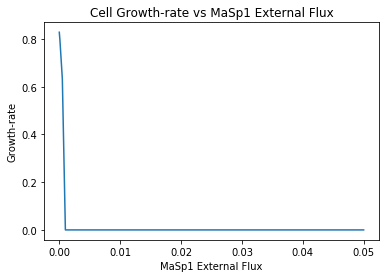

In [24]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1
# corresponding y axis values
y = growth_rate
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs MaSp1 External Flux')
  
# function to show the plot
plt.show()

In [25]:
from contextlib import suppress

MaSp1 = [0, 0.0001, 0.0005, 0.0006, 0.00065, 0.00066, 0.00067]
growth_rate2 = []
for x in MaSp1:
    print('\nMaSp1 Flux # ',x)
    me.reactions.get_by_id('DM_protein_MaSp1').lower_bound = x
    me.reactions.get_by_id('DM_protein_MaSp1').upper_bound = x
    temp = 0
    with suppress(Exception):
        solve_me_model(me, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        temp = me.solution.f    
    growth_rate2.append(temp)
    print('Growth-rate =', growth_rate2)
    
growth_rate2


MaSp1 Flux #  0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 34.029228 seconds
Finished substituting S,lb,ub in 2.276199 seconds
Finished makeME_LP in 0.356756 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.345308 seconds
Finished makeME_LP in 0.364974 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.309644 seconds
Finished makeME_LP in 0.363977 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.357829 seconds
Finished makeME_LP in 0.358353 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.361149 seconds
Finished makeME_LP in 0.363715 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.337886 seconds
Finished makeME_LP in 0.362449 seconds

1 0.0 0.0 0.5 0.5 1
Finished substituting S,lb,ub in 2.299053 seconds
Finished makeME_LP in 0.370126 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.315982 seconds
Finished makeME_LP in 0.372641 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.321443 seconds
Finished makeME_LP in 0.362462 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.320281 seconds
Finished makeME_LP in 0.362461 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 2.288368 seconds
Finished makeME_LP in 0.359992 seconds
Getting MINOS parameters from ME_NLP...
6 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 2.312298 seconds
Finished makeME_LP in 0.360047 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 501.309 seconds
Growth-rat

[0.828125, 0.796875, 0.6328125, 0.5703125, 0.5234375, 0.5078125, 0]

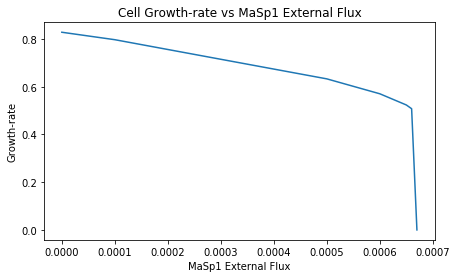

In [26]:
import matplotlib.pyplot as plt
  
# x axis values
x = MaSp1
# corresponding y axis values
y = growth_rate2

plt.figure(figsize=(7,4))

# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('MaSp1 External Flux')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Cell Growth-rate vs MaSp1 External Flux')
  
# function to show the plot
plt.show()